In [1]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Check versions
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)


Numpy version: 1.26.4
Pandas version: 2.2.2


In [2]:
# Step 2: Load datasets
epl_final = pd.read_csv("epl_final_clean.csv")
match_winner = pd.read_csv("match_winner_clean.csv")
pl_tables = pd.read_csv("pl_tables_clean.csv")
top_goals = pd.read_csv("top_goals_clean.csv")

# Print shapes
print("EPL Final shape:", epl_final.shape)
print("Match Winner shape:", match_winner.shape)
print("PL Tables shape:", pl_tables.shape)
print("Top Goals shape:", top_goals.shape)

# Display first few rows of PL tables
pl_tables.head()


EPL Final shape: (9380, 22)
Match Winner shape: (9380, 22)
PL Tables shape: (646, 12)
Top Goals shape: (324, 19)


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,notes
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,→ Champions League via league finish
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,→ UEFA Cup via league finish
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,→ UEFA Cup via league finish 1
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,Unknown
4,1993,QPR,5,42,17,12,13,63,55,8,63,Unknown


In [3]:
# Step 3: Overview of PL Tables
print("PL Tables Info:")
print(pl_tables.info())
print("\nSummary Stats:")
print(pl_tables.describe())

print("\nMissing Values:")
print(pl_tables.isnull().sum())


PL Tables Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   season_end_year  646 non-null    int64 
 1   team             646 non-null    object
 2   position         646 non-null    int64 
 3   played           646 non-null    int64 
 4   won              646 non-null    int64 
 5   drawn            646 non-null    int64 
 6   lost             646 non-null    int64 
 7   gf               646 non-null    int64 
 8   ga               646 non-null    int64 
 9   gd               646 non-null    int64 
 10  points           646 non-null    int64 
 11  notes            646 non-null    object
dtypes: int64(10), object(2)
memory usage: 60.7+ KB
None

Summary Stats:
       season_end_year    position      played         won       drawn  \
count       646.000000  646.000000  646.000000  646.000000  646.000000   
mean       2008.365325   10.

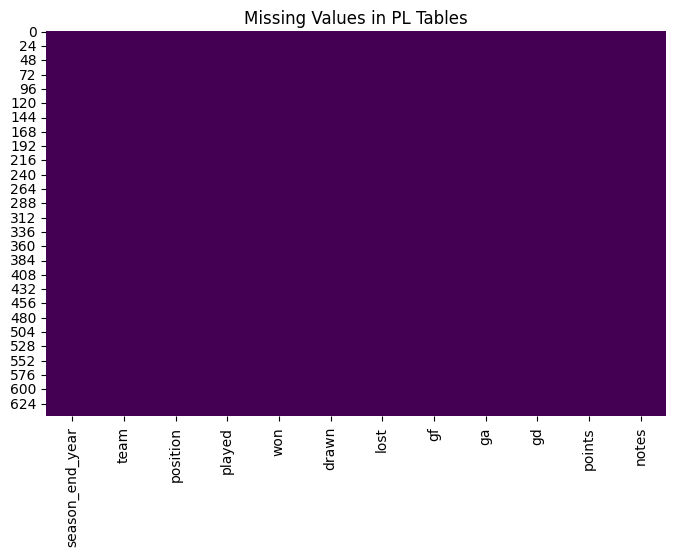

In [4]:
plt.figure(figsize=(8,5))
sns.heatmap(pl_tables.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in PL Tables")
plt.show()


In [5]:
# Drop notes column if exists
pl_tables = pl_tables.drop(columns=['notes'], errors='ignore')

# Fill numeric missing values with median
for col in pl_tables.select_dtypes(include=[np.number]).columns:
    pl_tables[col].fillna(pl_tables[col].median(), inplace=True)

# Fill categorical missing values with mode
for col in pl_tables.select_dtypes(include=['object']).columns:
    pl_tables[col].fillna(pl_tables[col].mode()[0], inplace=True)

print("Missing values after cleaning:\n", pl_tables.isnull().sum())


Missing values after cleaning:
 season_end_year    0
team               0
position           0
played             0
won                0
drawn              0
lost               0
gf                 0
ga                 0
gd                 0
points             0
dtype: int64


In [6]:
print("Duplicates before:", pl_tables.duplicated().sum())
pl_tables = pl_tables.drop_duplicates()
print("Duplicates after:", pl_tables.duplicated().sum())


Duplicates before: 0
Duplicates after: 0


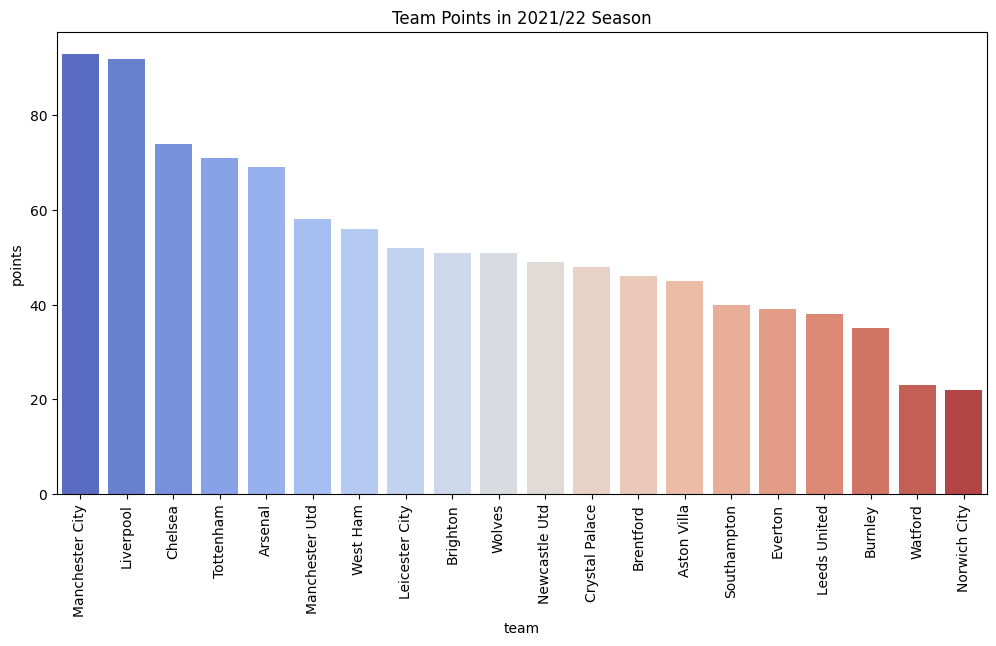

In [7]:
season_sample = pl_tables[pl_tables['season_end_year'] == 2022]
plt.figure(figsize=(12,6))
sns.barplot(data=season_sample, x='team', y='points', palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Team Points in 2021/22 Season")
plt.show()


In [8]:
le = LabelEncoder()
pl_tables['team_encoded'] = le.fit_transform(pl_tables['team'])
print(pl_tables[['team','team_encoded']].head())


             team  team_encoded
0  Manchester Utd            28
1     Aston Villa             1
2    Norwich City            31
3       Blackburn             4
4             QPR            35


In [9]:
pl_tables['win_ratio'] = pl_tables['won'] / pl_tables['played']
pl_tables['goal_efficiency'] = pl_tables['gf'] / pl_tables['played']
pl_tables.head()


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,team_encoded,win_ratio,goal_efficiency
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,28,0.571429,1.595238
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,1,0.500000,1.357143
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,31,0.500000,1.452381
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,4,0.476190,1.619048
4,1993,QPR,5,42,17,12,13,63,55,8,63,35,0.404762,1.500000


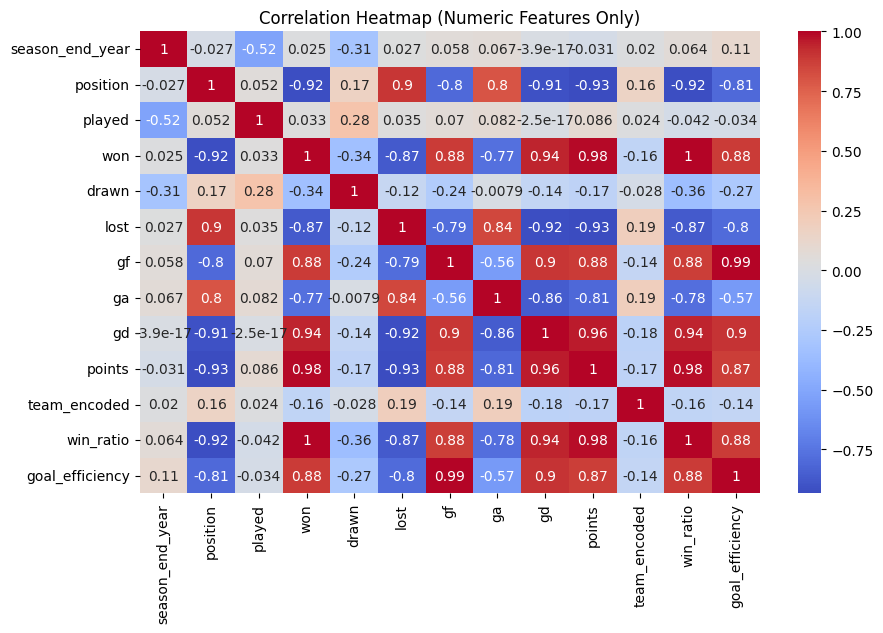

In [11]:
# Step 10: Correlation Heatmap (fixed)

# Select only numeric columns
numeric_data = pl_tables.select_dtypes(include=[np.number])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [12]:
X = pl_tables.drop(columns=['position','season_end_year','team'], errors='ignore')
X = X.select_dtypes(include=[np.number])
y = pl_tables['position']
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (646, 11)
Target shape: (646,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (516, 11)
Test set: (130, 11)


Accuracy (Logistic Regression): 0.2846153846153846

Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.71      0.71         7
           2       0.40      0.40      0.40         5
           3       0.17      0.11      0.13         9
           4       0.40      0.57      0.47         7
           5       0.14      0.14      0.14         7
           6       0.50      0.30      0.38        10
           7       0.33      0.25      0.29         8
           8       0.00      0.00      0.00         4
           9       0.18      0.50      0.27         4
          10       0.33      0.33      0.33         6
          11       0.50      0.10      0.17        10
          12       0.33      0.17      0.22         6
          13       0.29      0.22      0.25         9
          14       0.17      0.50      0.25         2
          15       0.10      0.33      0.15         3
          16       0.00      0.00      0.00        10
     

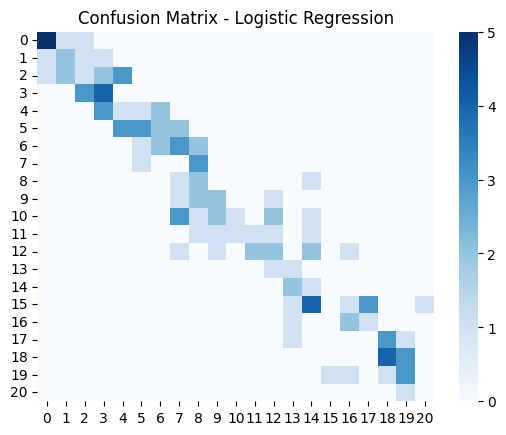

In [14]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=False, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Accuracy (Random Forest): 0.3153846153846154

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.86      0.86         7
           2       0.40      0.40      0.40         5
           3       0.33      0.22      0.27         9
           4       0.60      0.43      0.50         7
           5       0.18      0.29      0.22         7
           6       0.50      0.30      0.38        10
           7       0.33      0.25      0.29         8
           8       0.10      0.25      0.14         4
           9       0.25      0.50      0.33         4
          10       0.33      0.33      0.33         6
          11       0.33      0.10      0.15        10
          12       0.29      0.33      0.31         6
          13       0.50      0.22      0.31         9
          14       0.14      0.50      0.22         2
          15       0.30      1.00      0.46         3
          16       0.00      0.00      0.00        10
          1

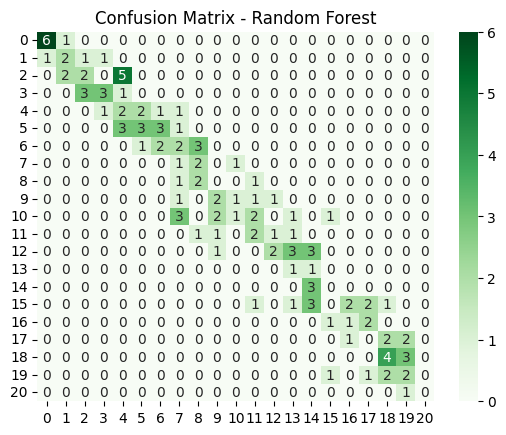

In [15]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [16]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))


Accuracy (Gradient Boosting): 0.2692307692307692


In [17]:
scores = cross_val_score(rf, X, y, cv=5)
print("Cross Validation Scores:", scores)
print("Average Accuracy:", scores.mean())


Cross Validation Scores: [0.19230769 0.26356589 0.3875969  0.24031008 0.30232558]
Average Accuracy: 0.2772212283840191


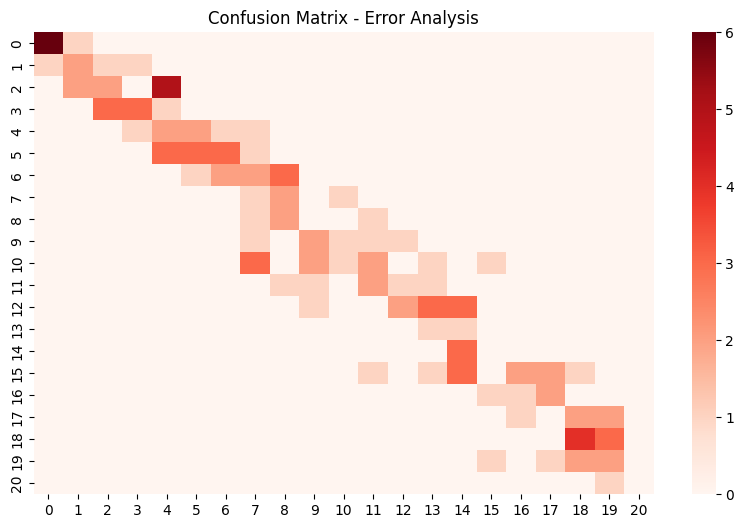

In [18]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,6))
sns.heatmap(cm, cmap="Reds", annot=False)
plt.title("Confusion Matrix - Error Analysis")
plt.show()


In [19]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
comparison.head(10)


,Actual,Predicted
633,8,8
367,2,3
338,13,15
292,7,8
72,7,6
436,11,14
598,13,14
616,11,12
512,7,9
174,9,9


In [ ]:
#  Results Summary

- Logistic Regression gave lower accuracy.  
- Random Forest performed better and captured patterns.  
- Gradient Boosting was in between.  


In [ ]:
#  Conclusion

This project applied ML to EPL standings.  
We predicted rankings (1–20) as a classification task.  
Although football has randomness, ML models still captured useful trends.  
Random Forest was the best performing model.  

⚽ **AI_Scoresight shows how ML can be applied to sports analytics!**
